## IMDB sentiment classification task

IMDB provided a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. 

We will train classifiers using CNN, RNN, LSTM and GRU for sentiment analysis

In [72]:
import numpy as np
import pandas as pd
import keras 
import random
import sys
np.random.seed(7) # fix random seed for reproducibility
%matplotlib inline

import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Keras Import

from keras.datasets import imdb,mnist

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, TimeDistributed, RepeatVector
from keras.layers.convolutional import Conv2D, MaxPooling2D,Conv1D,MaxPooling1D
from keras.layers import LSTM

from keras.optimizers import RMSprop
from keras.utils.data_utils import get_file

from keras.utils import np_utils
from keras.preprocessing import image,sequence
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM, GRU, SimpleRNN

from keras.callbacks import EarlyStopping, ModelCheckpoint#### IMDB sentiment classification task

#### Data Preparation - IMDB

(x_train, y_train), (x_test, y_test) = imdb.load_data(path="imdb_full.pkl",
                                                      num_words=None,
                                                      skip_top=0,
                                                      maxlen=None,
                                                      seed=113,
                                                      start_char=1)

#### Arguments:
Path: if you do not have the data locally (at '~/.keras/datasets/' + path), it will be downloaded to this location.

num_words: integer or None. Top most frequent words to consider. Any less frequent word will appear as 0 in the sequence data.

skip_top: integer. Top most frequent words to ignore (they will appear as 0s in the sequence data).

maxlen: int. Maximum sequence length. Any longer sequence will be truncated.

seed: int. Seed for reproducible data shuffling.

start_char: char. The start of a sequence will be marked with this character. Set to 1 because 0 is usually the padding character.


In [73]:
print("Loading data...")
(X_train, y_train), (X_test, y_test) = imdb.load_data()
print(len(X_train), 'train sequences')
print(len(X_test), 'test sequences')

Loading data...
25000 train sequences
25000 test sequences


In [74]:
X = np.concatenate((X_train, X_test), axis=0)
y = np.concatenate((y_train, y_test), axis=0)

In [75]:
# summarize size
print("Training data: ")
print(X.shape)
print(y.shape)
print("Classes: ")
print(np.unique(y))
print("Number of words: ")
print(len(np.unique(np.hstack(X))))

Training data: 
(50000,)
(50000,)
Classes: 
[0 1]
Number of words: 
88585


Review length: 
Mean 234.76 words (172.911495)


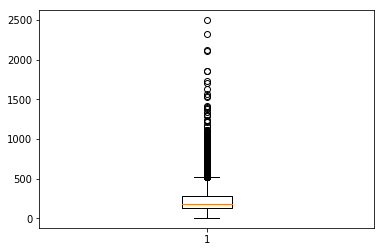

In [76]:
# Summarize review length
print("Review length: ")
result = [len(x) for x in X]
print("Mean %.2f words (%f)" % (np.mean(result), np.std(result)))
# plot review length
plt.boxplot(result)
plt.show()

### Pad sequence
keras.preprocessing.sequence.pad_sequences(sequences, maxlen=None, dtype='int32', padding='pre', truncating='pre', value=0.)

#### Arguments:

sequences: List of lists of int or float.
maxlen: None or int. Maximum sequence length, longer sequences are truncated and shorter sequences are padded with zeros at the end.

dtype: datatype of the Numpy array returned.

padding: 'pre' or 'post', pad either before or after each sequence.

truncating: 'pre' or 'post', remove values from sequences larger than maxlen either in the beginning or in the end of the sequence

value: float, value to pad the sequences to the desired value.

In [77]:
top_words = 5000
maxlen = 500  # cut texts after this number of words (among top top_words most common words)
batch_size = 32
max_features = 100
batch_size = 32

(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=top_words)
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)

example = 5
print('\nExample no.:',example)
print('\nLength of example:',len(X_train[example-1]))
print(X_train[example-1])

print("\nPadding sequences")
X_train = sequence.pad_sequences(X_train, maxlen=maxlen, padding='pre', truncating='post', value=0.)
X_test = sequence.pad_sequences(X_test, maxlen=maxlen, padding='pre', truncating='post', value=0.)
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('\nLength of example after pad_sequences:',len(X_train[example-1]))
print(X_train[example-1])


Example no.: 5

Length of example: 147
[1, 249, 1323, 7, 61, 113, 10, 10, 13, 1637, 14, 20, 56, 33, 2401, 18, 457, 88, 13, 2626, 1400, 45, 3171, 13, 70, 79, 49, 706, 919, 13, 16, 355, 340, 355, 1696, 96, 143, 4, 22, 32, 289, 7, 61, 369, 71, 2359, 5, 13, 16, 131, 2073, 249, 114, 249, 229, 249, 20, 13, 28, 126, 110, 13, 473, 8, 569, 61, 419, 56, 429, 6, 1513, 18, 35, 534, 95, 474, 570, 5, 25, 124, 138, 88, 12, 421, 1543, 52, 725, 2, 61, 419, 11, 13, 1571, 15, 1543, 20, 11, 4, 2, 5, 296, 12, 3524, 5, 15, 421, 128, 74, 233, 334, 207, 126, 224, 12, 562, 298, 2167, 1272, 7, 2601, 5, 516, 988, 43, 8, 79, 120, 15, 595, 13, 784, 25, 3171, 18, 165, 170, 143, 19, 14, 5, 2, 6, 226, 251, 7, 61, 113]

Pad sequences (samples x time)
X_train shape: (25000, 500)
X_test shape: (25000, 500)

Length of example after pad_sequences: 500
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0

### Embedding building 

keras.layers.embeddings.Embedding(input_dim, output_dim, embeddings_initializer='uniform', embeddings_regularizer=None, 
                                  activity_regularizer=None, embeddings_constraint=None, mask_zero=False, input_length=None)

#### Arguments:

input_dim: int > 0. Size of the vocabulary, ie. 1 + maximum integer index occurring in the input data.
    
output_dim: int >= 0. Dimension of the dense embedding.
    
embeddings_initializer: Initializer for the embeddings matrix (see initializers).
    
embeddings_regularizer: Regularizer function applied to the embeddings matrix (see regularizer).
    
embeddings_constraint: Constraint function applied to the embeddings matrix (see constraints).
    
mask_zero: Whether or not the input value 0 is a special "padding" value that should be masked out. This is useful when
using recurrent layers which may take variable length input. If this is True then all subsequent layers in the model need to support masking or an exception will be raised. 
If mask_zero is set to True, as a consequence, index 0 cannot be used in the vocabulary (input_dim should equal |vocabulary| + 2).

input_length: Length of input sequences, when it is constant. This argument is required if you are going to connect  Flatten then Dense layers upstream (without it, the shape of the dense outputs cannot be computed).

In [78]:
# creating NN model
model = Sequential()
model.add(Embedding(top_words, max_features , input_length=maxlen)) #Embedding(input_dim, output_dim, input_length)
model.add(Flatten())
model.add(Dense(250, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

# Fit the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=1, batch_size=batch_size)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 500, 100)          500000    
_________________________________________________________________
flatten_9 (Flatten)          (None, 50000)             0         
_________________________________________________________________
dense_17 (Dense)             (None, 250)               12500250  
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 251       
Total params: 13,000,501.0
Trainable params: 13,000,501.0
Non-trainable params: 0.0
_________________________________________________________________
None
Train on 25000 samples, validate on 25000 samples
Epoch 1/1
25000/25000 [==============================] - 219s - loss: 0.4704 - acc: 0.7360 - val_loss: 0.3535 - val_acc: 0.8442


In [79]:
# Trying CNN model
model = Sequential()
model.add(Embedding(top_words, max_features, input_length=maxlen))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(250, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

# Fit the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3, batch_size=128)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 500, 100)          500000    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 500, 32)           9632      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 250, 32)           0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 8000)              0         
_________________________________________________________________
dense_19 (Dense)             (None, 250)               2000250   
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 251       
Total params: 2,510,133.0
Trainable params: 2,510,133.0
Non-trainable params: 0.0
____________________________________________________________

Recurrent Neural networks
=====

### RNN  

<img src ="https://github.com/bhavsarpratik/Deep_Learning_Notebooks/raw/master/data/images/NH_WordTimeStep_SeparateRNNs.png" width="70%">

A recurrent neural network (RNN) is a class of artificial neural network where connections between units form a directed cycle. This creates an internal state of the network which allows it to exhibit dynamic temporal behavior.

```python
keras.layers.recurrent.SimpleRNN(units, activation='tanh', use_bias=True, 
                                 kernel_initializer='glorot_uniform', 
                                 recurrent_initializer='orthogonal', 
                                 bias_initializer='zeros', 
                                 kernel_regularizer=None, 
                                 recurrent_regularizer=None, 
                                 bias_regularizer=None, 
                                 activity_regularizer=None, 
                                 kernel_constraint=None, recurrent_constraint=None, 
                                 bias_constraint=None, dropout=0.0, recurrent_dropout=0.0)
```

#### Arguments:

<ul>
<li><strong>units</strong>: Positive integer, dimensionality of the output space.</li>
<li><strong>activation</strong>: Activation function to use
    (see <a href="http://keras.io/activations/">activations</a>).
    If you pass None, no activation is applied
    (ie. "linear" activation: <code>a(x) = x</code>).</li>
<li><strong>use_bias</strong>: Boolean, whether the layer uses a bias vector.</li>
<li><strong>kernel_initializer</strong>: Initializer for the <code>kernel</code> weights matrix,
    used for the linear transformation of the inputs.
    (see <a href="https://keras.io/initializers/">initializers</a>).</li>
<li><strong>recurrent_initializer</strong>: Initializer for the <code>recurrent_kernel</code>
    weights matrix,
    used for the linear transformation of the recurrent state.
    (see <a href="https://keras.io/initializers/">initializers</a>).</li>
<li><strong>bias_initializer</strong>: Initializer for the bias vector
    (see <a href="https://keras.io/initializers/">initializers</a>).</li>
<li><strong>kernel_regularizer</strong>: Regularizer function applied to
    the <code>kernel</code> weights matrix
    (see <a href="https://keras.io/regularizers/">regularizer</a>).</li>
<li><strong>recurrent_regularizer</strong>: Regularizer function applied to
    the <code>recurrent_kernel</code> weights matrix
    (see <a href="https://keras.io/regularizers/">regularizer</a>).</li>
<li><strong>bias_regularizer</strong>: Regularizer function applied to the bias vector
    (see <a href="https://keras.io/regularizers/">regularizer</a>).</li>
<li><strong>activity_regularizer</strong>: Regularizer function applied to
    the output of the layer (its "activation").
    (see <a href="https://keras.io/regularizers/">regularizer</a>).</li>
<li><strong>kernel_constraint</strong>: Constraint function applied to
    the <code>kernel</code> weights matrix
    (see <a href="https://keras.io/constraints/">constraints</a>).</li>
<li><strong>recurrent_constraint</strong>: Constraint function applied to
    the <code>recurrent_kernel</code> weights matrix
    (see <a href="https://keras.io/constraints/">constraints</a>).</li>
<li><strong>bias_constraint</strong>: Constraint function applied to the bias vector
    (see <a href="https://keras.io/constraints/">constraints</a>).</li>
<li><strong>dropout</strong>: Float between 0 and 1.
    Fraction of the units to drop for
    the linear transformation of the inputs.</li>
<li><strong>recurrent_dropout</strong>: Float between 0 and 1.
    Fraction of the units to drop for
    the linear transformation of the recurrent state.</li>
</ul>

#### Backprop Through time  

Contrary to feed-forward neural networks, the RNN is characterized by the ability of encoding longer past information, thus very suitable for sequential models. The BPTT extends the ordinary BP algorithm to suit the recurrent neural
architecture.

<img src ="https://github.com/bhavsarpratik/Deep_Learning_Notebooks/raw/master/data/images/rnn-bptt-with-gradients.png" width="55%">

**Reference**: [Backpropagation through Time](http://ir.hit.edu.cn/~jguo/docs/notes/bptt.pdf)

In [80]:
# Trying RNN model
print('Build model...')
model = Sequential()
model.add(Embedding(input_dim =top_words, output_dim = max_features, input_length=maxlen))
model.add(SimpleRNN(128))  
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))
print(model.summary())

# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print("Train...")
model.fit(X_train, y_train, batch_size=batch_size, epochs=1, validation_data=(X_test, y_test))

Build model...
Train...
Train on 25000 samples, validate on 25000 samples
Epoch 1/1
25000/25000 [==============================] - 290s - loss: 0.7224 - acc: 0.5278 - val_loss: 0.6269 - val_acc: 0.6404


### LSTM  

A LSTM network is an artificial neural network that contains LSTM blocks instead of, or in addition to, regular network units. A LSTM block may be described as a "smart" network unit that can remember a value for an arbitrary length of time. 

Unlike traditional RNNs, an Long short-term memory network is well-suited to learn from experience to classify, process and predict time series when there are very long time lags of unknown size between important events.

You can get a good understanding of them from this article
http://karpathy.github.io/2015/05/21/rnn-effectiveness/
https://colah.github.io/posts/2015-08-Understanding-LSTMs/
http://r2rt.com/written-memories-understanding-deriving-and-extending-the-lstm.html

<img src ="https://github.com/bhavsarpratik/Deep_Learning_Notebooks/raw/master/data/images/LSTM3-chain.png" width="60%">

```python
keras.layers.recurrent.LSTM(units, activation='tanh', recurrent_activation='hard_sigmoid', use_bias=True, 
                            kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal', 
                            bias_initializer='zeros', unit_forget_bias=True, kernel_regularizer=None, 
                            recurrent_regularizer=None, bias_regularizer=None, activity_regularizer=None, 
                            kernel_constraint=None, recurrent_constraint=None, bias_constraint=None, 
                            dropout=0.0, recurrent_dropout=0.0)
```

#### Arguments

<ul>
<li><strong>units</strong>: Positive integer, dimensionality of the output space.</li>
<li><strong>activation</strong>: Activation function to use
    If you pass None, no activation is applied
    (ie. "linear" activation: <code>a(x) = x</code>).</li>
<li><strong>recurrent_activation</strong>: Activation function to use
    for the recurrent step.</li>
<li><strong>use_bias</strong>: Boolean, whether the layer uses a bias vector.</li>
<li><strong>kernel_initializer</strong>: Initializer for the <code>kernel</code> weights matrix,
    used for the linear transformation of the inputs.</li>
<li><strong>recurrent_initializer</strong>: Initializer for the <code>recurrent_kernel</code>
    weights matrix,
    used for the linear transformation of the recurrent state.</li>
<li><strong>bias_initializer</strong>: Initializer for the bias vector.</li>
<li><strong>unit_forget_bias</strong>: Boolean.
    If True, add 1 to the bias of the forget gate at initialization.
    Setting it to true will also force <code>bias_initializer="zeros"</code>.
    This is recommended in <a href="http://www.jmlr.org/proceedings/papers/v37/jozefowicz15.pdf">Jozefowicz et al.</a></li>
<li><strong>kernel_regularizer</strong>: Regularizer function applied to
    the <code>kernel</code> weights matrix.</li>
<li><strong>recurrent_regularizer</strong>: Regularizer function applied to
    the <code>recurrent_kernel</code> weights matrix.</li>
<li><strong>bias_regularizer</strong>: Regularizer function applied to the bias vector.</li>
<li><strong>activity_regularizer</strong>: Regularizer function applied to
    the output of the layer (its "activation").</li>
<li><strong>kernel_constraint</strong>: Constraint function applied to
    the <code>kernel</code> weights matrix.</li>
<li><strong>recurrent_constraint</strong>: Constraint function applied to
    the <code>recurrent_kernel</code> weights matrix.</li>
<li><strong>bias_constraint</strong>: Constraint function applied to the bias vector.</li>
<li><strong>dropout</strong>: Float between 0 and 1.
    Fraction of the units to drop for
    the linear transformation of the inputs.</li>
<li><strong>recurrent_dropout</strong>: Float between 0 and 1.
    Fraction of the units to drop for
    the linear transformation of the recurrent state.</li>
</ul>

### GRU  

Gated recurrent units are a gating mechanism in recurrent neural networks. 

Much similar to the LSTMs, they have fewer parameters than LSTM, as they lack an output gate.

```python
keras.layers.recurrent.GRU(units, activation='tanh', recurrent_activation='hard_sigmoid', use_bias=True, 
                           kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal', 
                           bias_initializer='zeros', kernel_regularizer=None, recurrent_regularizer=None, 
                           bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, 
                           recurrent_constraint=None, bias_constraint=None, 
                           dropout=0.0, recurrent_dropout=0.0)
```

### Let's try LSTM and GRU

In [81]:
# Trying GRU model
print('Build model...')
model = Sequential()
model.add(Embedding(input_dim =top_words, output_dim = max_features, input_length=maxlen))
model.add(GRU(128))    
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))
print(model.summary())

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print("Train...")
model.fit(X_train, y_train, batch_size=batch_size, epochs=4, validation_data=(X_test, y_test))

Build model...
Train...
Train on 25000 samples, validate on 25000 samples
Epoch 1/4
25000/25000 [==============================] - 717s - loss: 0.4680 - acc: 0.7703 - val_loss: 0.3667 - val_acc: 0.8394
Epoch 2/4
25000/25000 [==============================] - 633s - loss: 0.3143 - acc: 0.8694 - val_loss: 0.2825 - val_acc: 0.8812
Epoch 3/4
25000/25000 [==============================] - 760s - loss: 0.2120 - acc: 0.9178 - val_loss: 0.2771 - val_acc: 0.8871
Epoch 4/4
25000/25000 [==============================] - 113s   
Test score: 0.293660580378
Test accuracy: 0.88588


In [ ]:
# Trying LSTM model
print('Build model...')
model = Sequential()
model.add(Embedding(input_dim =top_words, output_dim = max_features, input_length=maxlen))
model.add(LSTM(128))  
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))
print(model.summary())

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print("Train...")
model.fit(X_train, y_train, batch_size=batch_size, epochs=4, validation_data=(X_test, y_test))

# Sentence Generation using RNN(LSTM)

In [ ]:
path = get_file('nietzsche.txt', origin="https://s3.amazonaws.com/text-datasets/nietzsche.txt")
text = open(path).read().lower()
print('corpus length:', len(text))

chars = sorted(list(set(text)))
print('total chars:', len(chars))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

# cut the text in semi-redundant sequences of maxlen characters
maxlen = 40
step = 3
sentences = []
next_chars = []
for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i: i + maxlen])
    next_chars.append(text[i + maxlen])
print('nb sequences:', len(sentences))

print('Vectorization...')
X = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        X[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1


# build the model: a single LSTM
print('Build model...')
model = Sequential()
model.add(LSTM(128, input_shape=(maxlen, len(chars))))
model.add(Dense(len(chars)))
model.add(Activation('softmax'))
print(model.summary())

optimizer = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)


def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

# train the model, output generated text after each iteration
for iteration in range(1, 60):
    print()
    print('-' * 50)
    print('Iteration', iteration)
    model.fit(X, y, batch_size=128, nb_epoch=1)

    start_index = random.randint(0, len(text) - maxlen - 1)

    for diversity in [0.2, 0.5, 1.0, 1.2]:
        print()
        print('----- diversity:', diversity)

        generated = ''
        sentence = text[start_index: start_index + maxlen]
        generated += sentence
        print('----- Generating with seed: "' + sentence + '"')
        sys.stdout.write(generated)

        for i in range(400):
            x = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(sentence):
                x[0, t, char_indices[char]] = 1.

            preds = model.predict(x, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = indices_char[next_index]

            generated += next_char
            sentence = sentence[1:] + next_char

            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()